In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

First, we need to add a new neuron model to nengo.  It has a RectifiedLinear neuron already, but it doesn't have an option to set a threshold.  So here we just subclass that model and create that parameter.

Note that we could also do something similar to set a maximum output for the ReLU as well.

In [3]:
class RectifiedLinearWithThreshold(nengo.RectifiedLinear):
    threshold = nengo.params.NumberParam('threshold')

    def __init__(self, amplitude=1, threshold=0):
        super().__init__(amplitude=amplitude)
        self.threshold = threshold

    def step_math(self, dt, J, output):
        output[...] = self.amplitude * np.where(J>self.threshold, J, 0)
        


Now we make a new neuron model: the (non-spiking) leaky integrator.  We base this on the existing LIF model (since it already has a voltage as an internal state variable).

In [4]:
class LeakyIntegrator(nengo.LIF):
    threshold = nengo.params.NumberParam('threshold')
    
    def __init__(self, amplitude=1, threshold=0, tau_rc=0.02, min_voltage=0):
        super().__init__(amplitude=amplitude, tau_rc=tau_rc, tau_ref=0, min_voltage=min_voltage)
        self.threshold = threshold
        
    def step_math(self, dt, J, output, voltage, refractory_time):
        # to map to the paper: output is y, voltage is u, and J is the inputs times the dictionary matrix
        
        # y = T(u)
        output[:] = np.where(voltage>self.threshold, voltage, 0)
        
        # du/dt = -u + y + phi*r
        dv = -voltage + output + J
        
        # perform the voltage update
        voltage += dv*(dt/self.tau_rc)
        
        # limit the voltage to positive only
        voltage[voltage < self.min_voltage] = self.min_voltage

For the V1->Residual connection, we need a sign-flipped Oja rule.  This can be done by setting a negative learning rate for the normal Oja rule.  However, nengo currently disallows a negative value for a learning rate.  So, we implement a negative variant of the Oja rule.

In [15]:
class NegOja(nengo.Oja):
    pass

from nengo.builder.learning_rules import SimOja, get_pre_ens, get_post_ens, build_or_passthrough

@nengo.builder.Builder.register(NegOja)
def build_negoja(model, oja, rule):
    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]['out']
    post_activities = model.sig[get_post_ens(conn).neurons]['out']
    pre_filtered = build_or_passthrough(model, oja.pre_synapse, pre_activities)
    post_filtered = build_or_passthrough(
        model, oja.post_synapse, post_activities)

    model.add_op(SimOja(pre_filtered,
                        post_filtered,
                        model.sig[conn]['weights'],
                        model.sig[rule]['delta'],
                        learning_rate=-oja.learning_rate,
                        beta=oja.beta))

    # expose these for probes
    model.sig[rule]['pre_filtered'] = pre_filtered
    model.sig[rule]['post_filtered'] = post_filtered

Now we build our model.  We have three basic "layers":  the image, the residual, and v1

In [16]:
seed = 10
np.random.seed(seed=seed)

N = 10    # size of the input
J = 50    # number of neurons

# generate an example image
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

model = nengo.Network(seed=seed)
with model:
    # the input, which will be N-dimensional 
    #  (note that we can replace this with input that changes over time to give a more real-world example)
    stim = nengo.Node(image)
    
    # for the residual, we use N neurons which are ReLU neurons with a threshold of -infinity.  That is, 
    # there is no nonlinearity here at all.
    residual = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=-np.inf),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=LeakyIntegrator(threshold=0.1, tau_rc=0.001),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))

    # the initial dictionary
    w = np.random.uniform(-0.1, 0.1, (J, N))
    
    # now we make the learning connections.  Nengo has Oja built in, which is Hebbian with a 
    # stabilizing factor.  We can set beta=0 to get rid of that factor, to make it just Hebbian.
    learning_rate=1e-1
        
    tau = 0        # low-pass filter to use when using the w matrix
    tau_learn = 0  # low-pass filter to use when computing the Hebbian update
        
    c1 = nengo.Connection(residual.neurons, v1.neurons, transform=w, synapse=tau,
                     learning_rule_type=nengo.Oja(beta=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=learning_rate))
        
    c2 = nengo.Connection(v1.neurons, residual.neurons, transform=-w.T, synapse=tau,
                     learning_rule_type=NegOja(beta=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=learning_rate))
    
    # subtract the reconstruction from the stim to get the residual layer
    nengo.Connection(stim, residual.neurons, synapse=0)
    
    # record data from each layer
    p_v1 = nengo.Probe(v1.neurons)
    p_res = nengo.Probe(residual.neurons)
    p_c1 = nengo.Probe(c1, 'weights')
    p_c2 = nengo.Probe(c2, 'weights')
    
    
sim = nengo.Simulator(model)
sim.run(0.4)
                        

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

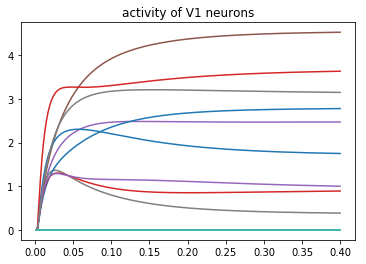

In [17]:
plt.plot(sim.trange(), sim.data[p_v1])
plt.title('activity of V1 neurons')
plt.show()

Now what does the reconstruction look like?

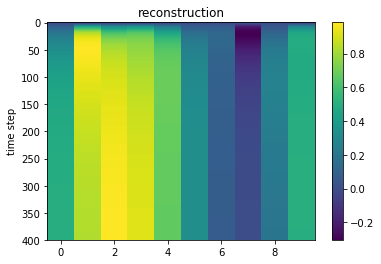

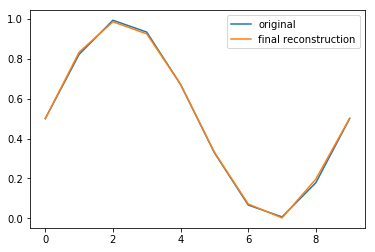

In [18]:
w = sim.data[p_c1]    # the weight matrix at each point in time
v1 = sim.data[p_v1]   # the activity of V1 over time



recon = np.zeros((w.shape[0], w.shape[2]))
for i in range(w.shape[0]):
    recon[i] = np.dot(v1[i], w[i])
# TODO: figure out a nicer way to do the above math in numpy    
    
plt.imshow(recon, aspect='auto')
plt.ylabel('time step')
plt.title('reconstruction')
plt.colorbar()
plt.figure()
plt.plot(image, label='original')
plt.plot(recon[-1], label='final reconstruction')
plt.legend()
plt.show()

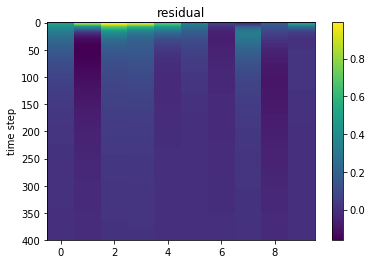

In [19]:
plt.imshow(sim.data[p_res][:,:], aspect='auto')
plt.ylabel('time step')
plt.title('residual')
plt.colorbar()


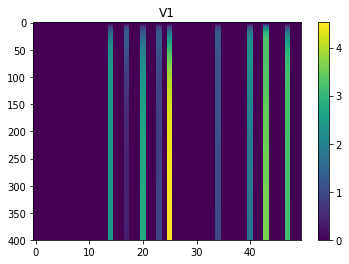

In [20]:
plt.imshow(sim.data[p_v1], aspect='auto')
plt.colorbar()
plt.title('V1')
plt.show()